In [61]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [57]:
class AdaBoostClassifier_:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = np.zeros(n_estimators)
        self.estimator_errors = np.zeros(n_estimators)
        
    def fit(self, X, y):
        # Initialize sample weights
        w = np.ones(len(X)) / len(X)
        
        for i in range(self.n_estimators):
            # Train a decision tree classifier on the weighted samples
            estimator = DecisionTreeClassifier(max_depth=10, random_state=11)
            estimator.fit(X, y, sample_weight=w)
            
            # Compute weighted error and estimator weight
            incorrect = estimator.predict(X) != y
            epsilon = np.dot(incorrect, w)
            beta = epsilon / (1 - epsilon)
            
            # Update sample weights
            w *= np.power(beta, 1 - incorrect)
            w /= np.sum(w)
            
            # Save estimator and its weight and error
            self.estimators.append(estimator)
            self.estimator_weights[i] = np.log(1 / beta)
            self.estimator_errors[i] = epsilon
            
    def predict(self, X):
        # Compute weighted sum of predictions from all estimators
        scores = np.zeros(len(X))
        for i in range(self.n_estimators):
            scores += self.estimator_weights[i] * self.estimators[i].predict(X)
        return np.sign(scores)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


In [58]:
# Generate X1, X2, ..., X10 from N(0, 1)
X = np.random.normal(size=(12000, 10))

# Calculate the median of chi squared distribution with 10 degrees of freedom
chi2_median = np.median(np.random.chisquare(df=10, size=(10000,)))

# Set Y to 1 if P10 j=1 Xj^2 > median and -1 otherwise
Y = np.where(np.sum(X**2, axis=1) > chi2_median, 1, -1)

# Split into training and testing sets
X_train, Y_train = X[:2000], Y[:2000]
X_test, Y_test = X[2000:], Y[2000:]

In [59]:
clf = AdaBoostClassifier_()
clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)
print(score)

0.8305


In [60]:
tree = DecisionTreeClassifier()
stump = DecisionTreeClassifier(max_depth=1)
bag = BaggingClassifier(n_estimators=50)
boost = AdaBoostClassifier(n_estimators=50)
rf = RandomForestClassifier(n_estimators=50)
gradboost = GradientBoostingClassifier(n_estimators=50)
xgb = XGBClassifier(n_estimators=50)

classifiers = [('Decision tree', tree),('Decision stump', stump), ('Bagging', bag), ('Random forest', rf), 
               ('Gradient boosting', gradboost), ('XGBoost', xgb)]
for clf_name, clf in classifiers:
    if clf_name == 'XGBoost':
        scores = cross_val_score(clf, X, np.where(Y==-1, 0, 1), cv=10)
    else:
        scores = cross_val_score(clf, X, Y, cv=10)
    print(clf_name + ': %0.3f (+/- %0.3f)' % (scores.mean(), scores.std() * 2))

Decision tree: 0.794 (+/- 0.017)
Decision stump: 0.539 (+/- 0.014)
Bagging: 0.887 (+/- 0.013)
Random forest: 0.892 (+/- 0.019)
Gradient boosting: 0.889 (+/- 0.019)
XGBoost: 0.927 (+/- 0.016)


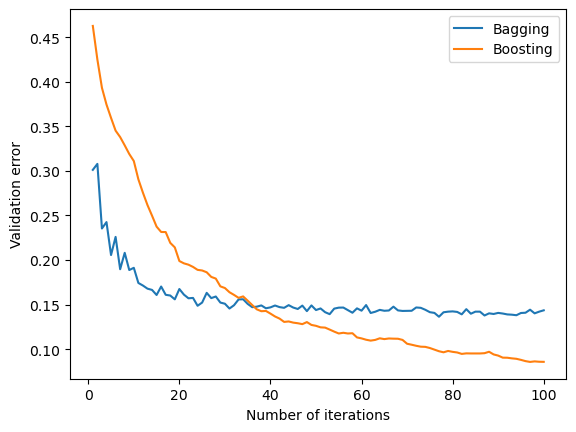

In [62]:
bag_errors = []
boost_errors = []
for n in range(1, 101):
    bag.n_estimators = n
    boost.n_estimators = n
    bag.fit(X_train, Y_train)
    boost.fit(X_train, Y_train)
    Y_pred_bag = bag.predict(X_test)
    Y_pred_boost = boost.predict(X_test)
    bag_errors.append(1 - accuracy_score(Y_test, Y_pred_bag))
    boost_errors.append(1 - accuracy_score(Y_test, Y_pred_boost))

# Plot errors vs number of iterations
plt.plot(range(1, 101), bag_errors, label='Bagging')
plt.plot(range(1, 101), boost_errors, label='Boosting')
plt.xlabel('Number of iterations')
plt.ylabel('Validation error')
plt.legend()
plt.show()